In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [7]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=np.ones(np.size(cj.phi1))*12*u.kpc,
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [8]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

color_mask = ((g.phot_g_mean_mag > (5*g.bp_rp + 14*u.mag)) | 
              (g.phot_g_mean_mag < (5*g.bp_rp + 10.5*u.mag))) & (g.bp_rp<1.2*u.mag)
pmeq_mask = (g.pmra>5*u.mas/u.yr) & (g.pmra<10*u.mas/u.yr) & (g.pmdec>-10*u.mas/u.yr) & (g.pmdec<-5*u.mas/u.yr)
pm_mask = ((cj.pm_phi1_cosphi2<-3.5*u.mas/u.yr) & (cj.pm_phi1_cosphi2>-8*u.mas/u.yr) & 
          (cj.pm_phi2<3*u.mas/u.yr) & (cj.pm_phi2>-2.5*u.mas/u.yr))
pm_mask = ((cj.pm_phi1_cosphi2<-4*u.mas/u.yr) & (cj.pm_phi1_cosphi2>-7*u.mas/u.yr) & 
          (cj.pm_phi2<3*u.mas/u.yr) & (cj.pm_phi2>-1*u.mas/u.yr))

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


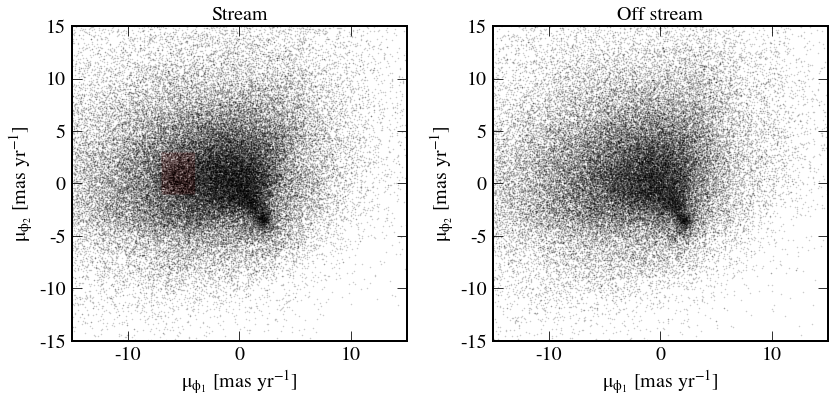

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[phi2_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask].to(u.mas/u.yr), 'k.', ms=1, alpha=0.2)
plt.plot(cj.pm_phi1_cosphi2[phi2_mask & pm_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask & pm_mask].to(u.mas/u.yr), 
         'r.', ms=1, alpha=0.05, zorder=0)
# plt.plot(cj.pm_phi1_cosphi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[phi2off_mask].to(u.mas/u.yr), cj.pm_phi2[phi2off_mask].to(u.mas/u.yr), 
         'k.', ms=1, alpha=0.2)
# plt.plot(cj.pm_phi1_cosphi2[phi2off_mask & pm_mask].to(u.mas/u.yr), cj.pm_phi2[phi2off_mask & pm_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

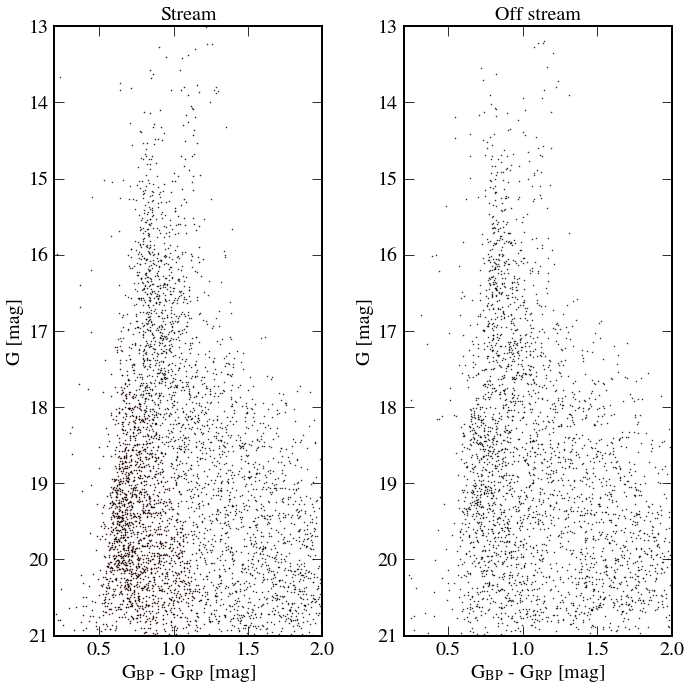

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
plt.sca(ax[0])
plt.plot(g.bp_rp[phi2_mask & pm_mask], g.phot_g_mean_mag[phi2_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.plot(g.bp_rp[phi2_mask & pm_mask & color_mask], g.phot_g_mean_mag[phi2_mask & pm_mask & color_mask], 
         'r.', alpha=0.3, ms=1, zorder=0)
plt.xlim(0.2,2)
plt.ylim(21, 13)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel('G [mag]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.bp_rp[phi2off_mask & pm_mask], g.phot_g_mean_mag[phi2off_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.xlim(0.2,2)
plt.ylim(21, 13)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel('G [mag]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

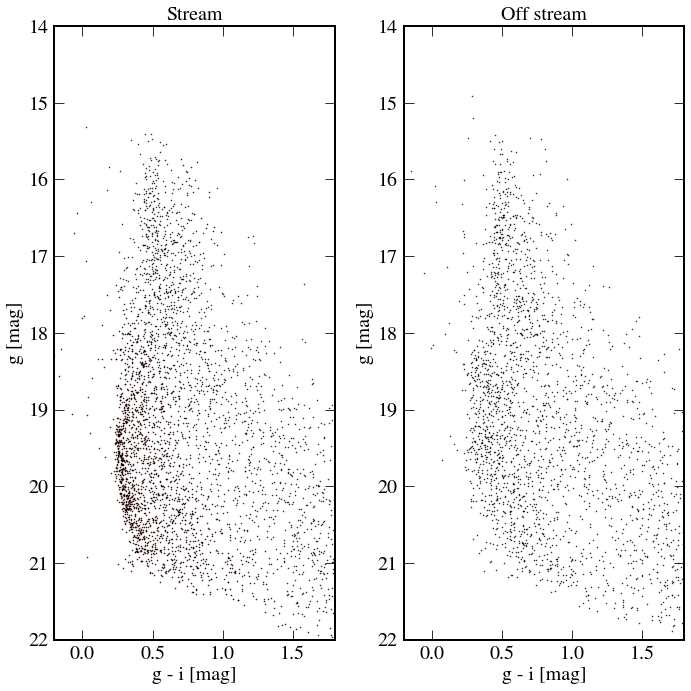

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
plt.sca(ax[0])
plt.plot(g.g0[phi2_mask & pm_mask]-g.i0[phi2_mask & pm_mask], 
         g.g0[phi2_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.plot(g.g0[phi2_mask & pm_mask & color_mask]-g.i0[phi2_mask & pm_mask & color_mask], 
         g.g0[phi2_mask & pm_mask & color_mask], 
         'r.', alpha=0.3, ms=1, zorder=0)
plt.xlim(-0.2,1.8)
plt.ylim(22, 14)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.g0[phi2off_mask & pm_mask]-g.i0[phi2off_mask & pm_mask], 
         g.g0[phi2off_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.xlim(-0.2,1.8)
plt.ylim(22, 14)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

In [12]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [13]:
# distance modulus
distance_app = 13.2*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

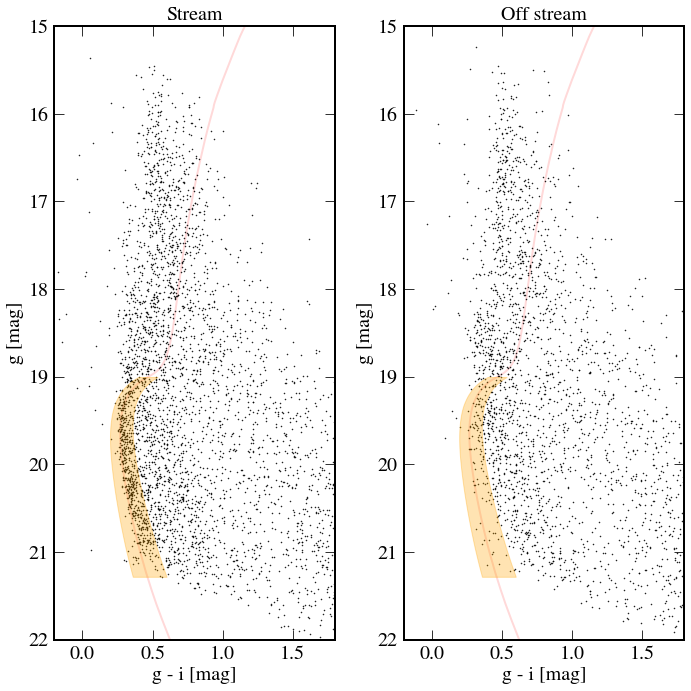

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
plt.sca(ax[0])
plt.plot(g.g[phi2_mask & pm_mask] - g.i[phi2_mask & pm_mask], g.g[phi2_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlim(-0.2,1.8)
plt.ylim(22, 15)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.g[phi2off_mask & pm_mask] - g.i[phi2off_mask & pm_mask], g.g[phi2off_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlim(-0.2,1.8)
plt.ylim(22, 15)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()
plt.savefig('../plots/jhelum_cmd.png')

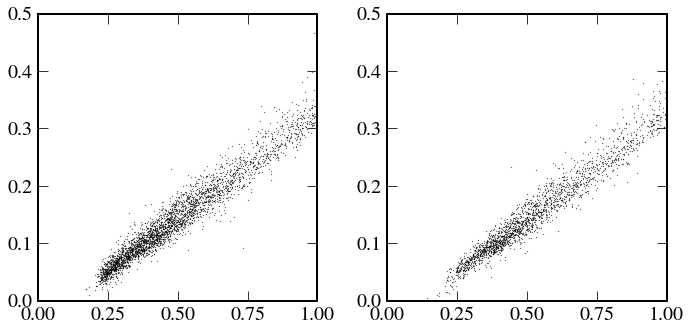

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(g.g[phi2_mask & pm_mask] - g.r[phi2_mask & pm_mask], g.r[phi2_mask & pm_mask] - g.i[phi2_mask & pm_mask],
        'k.', ms=0.5)
plt.xlim(0,1)
plt.ylim(0,0.5)

plt.sca(ax[1])
plt.plot(g.g[phi2off_mask & pm_mask] - g.r[phi2off_mask & pm_mask],
         g.r[phi2off_mask & pm_mask] - g.i[phi2off_mask & pm_mask],
        'k.', ms=0.5)
plt.xlim(0,1)
plt.ylim(0,0.5)

plt.tight_layout()

In [16]:
wangle = 180*u.deg

In [17]:
points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

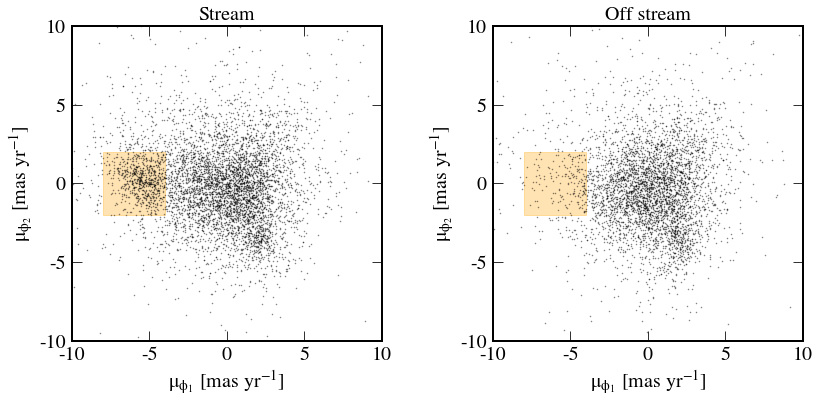

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

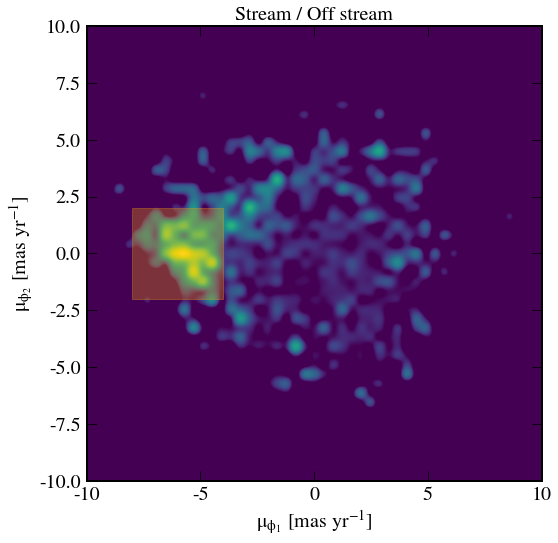

In [19]:
bx = np.linspace(-10,10,50)
Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hratio = np.zeros_like(Hon)
Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
Hratio[Hratio==0] = 0.1

plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
          interpolation='gaussian')

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream / Off stream', fontsize='medium')

plt.tight_layout()

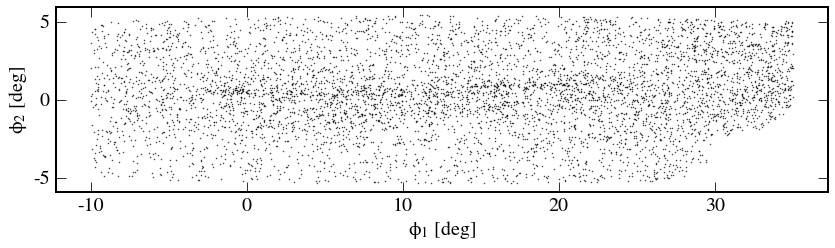

In [20]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.8)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()
plt.savefig('../plots/jhelum_map.png')

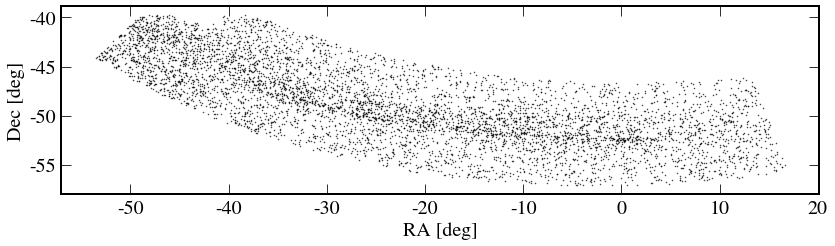

In [21]:
wangle_eq = 180*u.deg

plt.figure(figsize=(12,10))
plt.plot(coord.Angle(g.ra[pm_mask & cmd_mask]).wrap_at(wangle_eq), g.dec[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.8)
plt.gca().set_aspect('equal')

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.tight_layout()

In [22]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<28*u.deg)

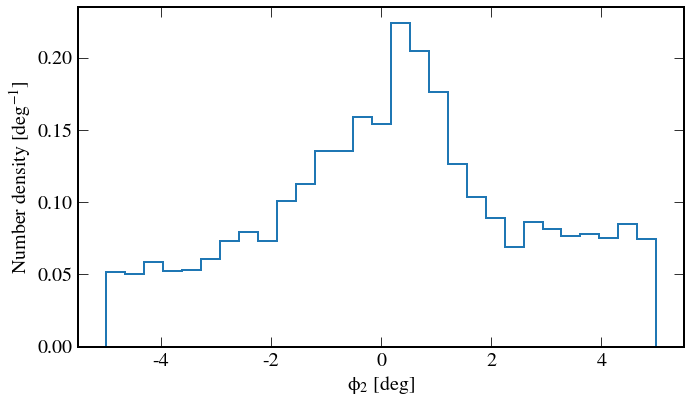

In [27]:
bins = np.linspace(-5,5,30)

plt.figure(figsize=(10,6))
x_snake = np.tanh(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value)
x_snake = cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value
nstream, bins, patches = plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
                                  bins=bins, histtype='step', lw=2, normed=True)
# plt.hist(cj.phi2[cmd_mask & phi1_mask].to(u.deg).value, bins=30, histtype='step', lw=2, normed=True)
# plt.hist(cj.phi2[pm_mask & phi1_mask].to(u.deg).value, bins=30, histtype='step', lw=2, normed=True)
ncont, bins, patches = plt.hist(cj.phi2[phi1_mask].to(u.deg).value, color='tab:blue', alpha=0.0,
                                bins=bins, histtype='step', lw=2, normed=True)

# plt.gca().set_yscale('log')
plt.xlabel('$\phi_2$ [deg]')
plt.ylabel('Number density [deg$^{-1}$]')
plt.tight_layout()
plt.savefig('../plots/jhelum_profile.png')

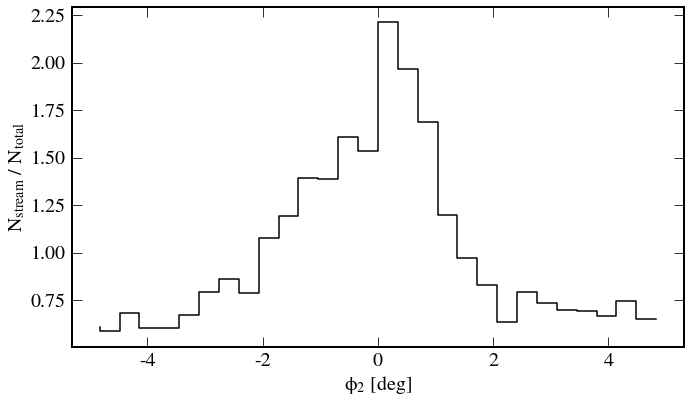

In [28]:
bcen = 0.5*(bins[1:] + bins[:-1])

plt.figure(figsize=(10,6))
plt.step(bcen, nstream/ncont, 'k')

plt.xlabel('$\phi_2$ [deg]')
plt.ylabel('$N_{stream}$ / $N_{total}$')
plt.tight_layout()

In [29]:
kde_stream = scipy.stats.gaussian_kde(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, bw_method=0.1)
kde_total = scipy.stats.gaussian_kde(cj.phi2[phi1_mask].to(u.deg).value, bw_method=0.1)

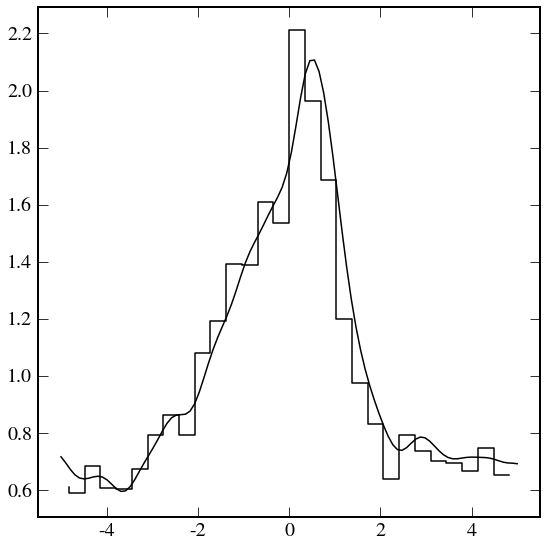

In [30]:
positions = np.linspace(-5,5,100)
plt.plot(positions, kde_stream.pdf(positions) / kde_total.pdf(positions), 'k-')
# plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, bins=bins, histtype='step', lw=2, normed=True)
plt.step(bcen, nstream/ncont, 'k')

plt.tight_layout()

## Proper motion profile

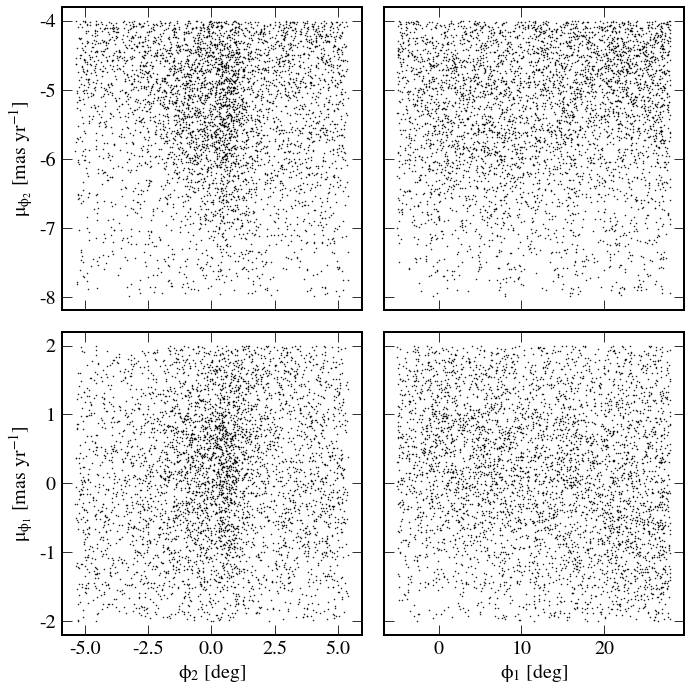

In [31]:
fig, ax = plt.subplots(2,2,figsize=(10,10), sharex='col', sharey='row')

plt.sca(ax[0][0])
plt.plot(cj.phi2[pm_mask & cmd_mask & phi1_mask],
         cj.pm_phi1_cosphi2[pm_mask & cmd_mask & phi1_mask].to(u.mas/u.yr),
        'k.', ms=1)

plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(cj.phi2[pm_mask & cmd_mask & phi1_mask],
         cj.pm_phi2[pm_mask & cmd_mask & phi1_mask].to(u.mas/u.yr),
        'k.', ms=1)

plt.ylabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.xlabel('$\phi_2$ [deg]')

plt.sca(ax[0][1])
plt.plot(cj.phi1[pm_mask & cmd_mask & phi1_mask].wrap_at(wangle), 
         cj.pm_phi1_cosphi2[pm_mask & cmd_mask & phi1_mask].to(u.mas/u.yr),
        'k.', ms=1)

plt.sca(ax[1][1])
plt.plot(cj.phi1[pm_mask & cmd_mask & phi1_mask].wrap_at(wangle), 
         cj.pm_phi2[pm_mask & cmd_mask & phi1_mask].to(u.mas/u.yr),
        'k.', ms=1)

plt.xlabel('$\phi_1$ [deg]')

plt.tight_layout()

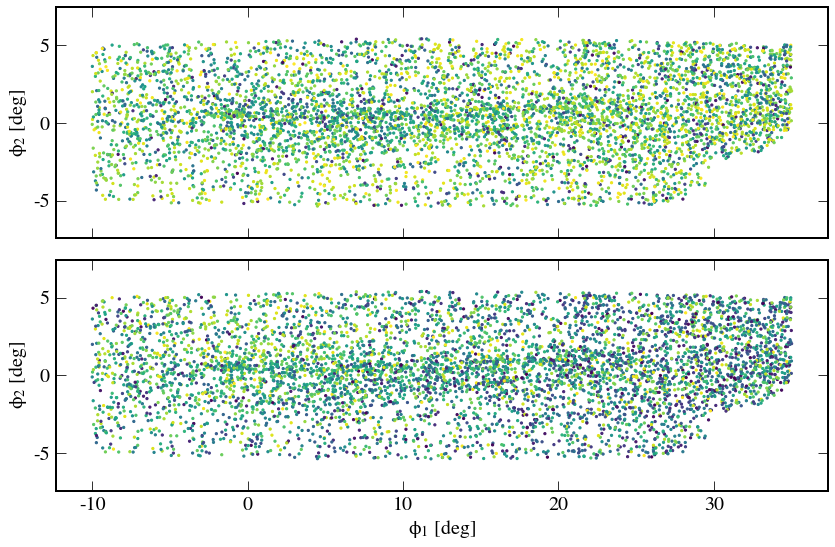

In [32]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

plt.sca(ax[0])
plt.scatter(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask],
           c=cj.pm_phi1_cosphi2[pm_mask & cmd_mask].to(u.mas/u.yr), s=5)
plt.gca().set_aspect('equal')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
plt.scatter(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask],
           c=cj.pm_phi2[pm_mask & cmd_mask].to(u.mas/u.yr), s=5)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [33]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [34]:
# setup bins for finding track
bin_size = 4 # deg
bin_l = np.arange(-5, (30-bin_size)+1, 2.)
bin_r = bin_l + bin_size
bin_c = 0.5 * (bin_l+bin_r)

bins_nonoverlap = np.arange(-5, (30-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

In [35]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 2.*u.deg) & (cj.phi2 > -3.*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 30, 100)
phi2_ = polytrack(phi1_)

In [36]:
# set up running median bins, arrays
bin_size = 1 # deg
bin_l = np.arange(-5, (30-bin_size)+1, 1.)
bin_r = bin_l + bin_size
bins_phi1 = 0.5 * (bin_l+bin_r)

Nbins = len(bin_l)
n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_p = np.zeros(Nbins)*u.mas
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_p_err = np.zeros(Nbins)*u.mas
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

In [37]:
# stream track properties
phi2_poly = polytrack(cj.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))
off_phi2 = 3
delta_phi2 = 2
_phi1 = cj.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).degree

for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
    sel_back = ((np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(cj.phi2[pm_mask & cmd_mask][selection])
    w[i] = mad_std(cj.phi2[pm_mask & cmd_mask][selection])
    
    rmed_p[i] = np.nanmedian(g.parallax[pm_mask & cmd_mask][selection])
    rmed_p_err[i] = mad_std(g.parallax[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(cj.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad_std(cj.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(cj.pm_phi2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad_std(cj.pm_phi2[pm_mask & cmd_mask][selection])
    
density = (n-n_back)/(2*delta_phi2*bin_size)

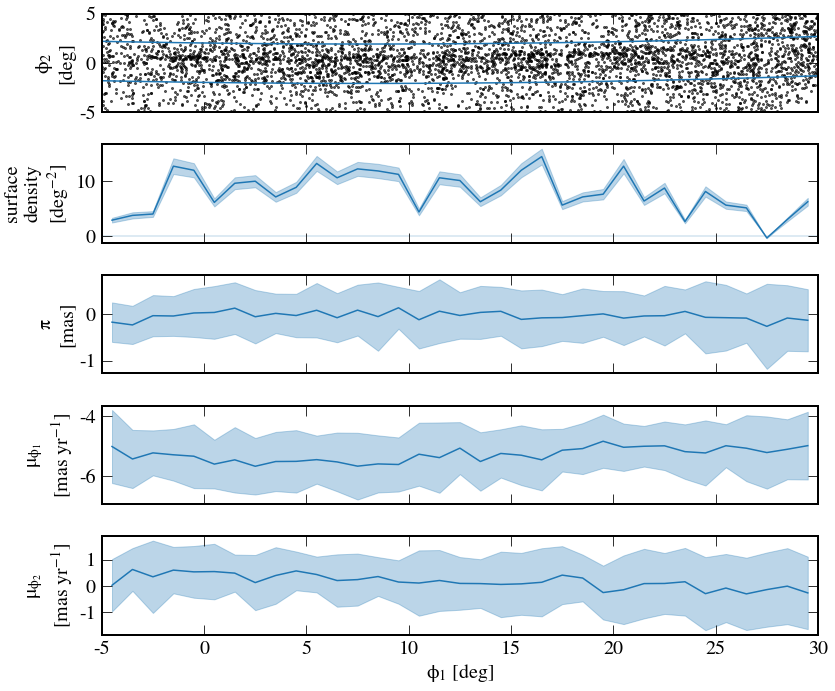

In [38]:
fig, axes = plt.subplots(5, 1, figsize=(12,10), sharex=True)

ax = axes[0]
ax.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), 
        cj.phi2[pm_mask & cmd_mask], 
        'ko', ms=2, alpha=0.6, rasterized=True)

ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-5, 5)

ax = axes[1]
ax.plot(bins_phi1, density, '-', label='data')
ax.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), 
                color='tab:blue', alpha=0.3)
ax.axhline(0, zorder=-10, alpha=0.2)
ax.set_ylabel('surface\ndensity\n[deg$^{-2}$]')

# parallax track
ax = axes[2]
ax.plot(bins_phi1, rmed_p, '-')
ax.fill_between(bins_phi1, rmed_p-rmed_p_err, rmed_p+rmed_p_err, 
                color='tab:blue', alpha=0.3)

ax.set_ylabel('$\pi$\n[mas]')

ax = axes[3]
ax.plot(bins_phi1, rmed_pmphi1, '-')
ax.fill_between(bins_phi1, rmed_pmphi1-rmed_pmphi1_err, rmed_pmphi1+rmed_pmphi1_err, 
                color='tab:blue', alpha=0.3)
ax.set_ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

ax = axes[4]
ax.plot(bins_phi1, rmed_pmphi2, '-')
ax.fill_between(bins_phi1, rmed_pmphi2-rmed_pmphi2_err, rmed_pmphi2+rmed_pmphi2_err, 
                color='tab:blue', alpha=0.3)
ax.set_xlabel('$\phi_1$ [deg]')
ax.set_ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

axes[0].set_xlim(-5, 30)

fig.tight_layout()

## Artifacts

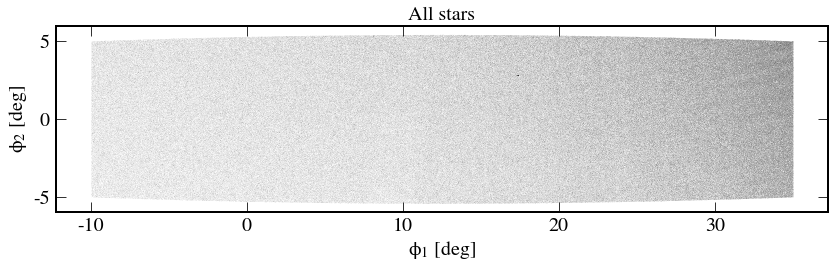

In [39]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.plot(cj.phi1.wrap_at(wangle), cj.phi2, 'k.', ms=0.5, alpha=0.02, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('All stars', fontsize='medium')

plt.tight_layout()

6 [ 8.  9. 10. 11. 14.]


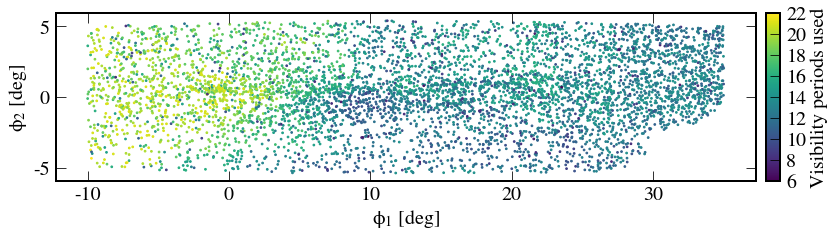

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
im = plt.scatter(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask],
           c=g.visibility_periods_used[pm_mask & cmd_mask], s=3)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(im, cax=cax)
plt.ylabel('Visibility periods used')

print(np.min(g.visibility_periods_used[pm_mask & cmd_mask]), 
      np.percentile(g.visibility_periods_used[pm_mask & cmd_mask], [1,2,5,10,50]))

plt.tight_layout()

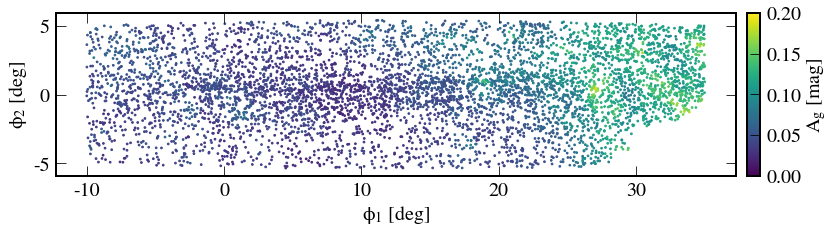

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
im = plt.scatter(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask],
           c=g.g[pm_mask & cmd_mask] - g.g0[pm_mask & cmd_mask], s=3, vmin=0, vmax=0.2)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
# plt.title('$A_g$', fontsize='medium')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(im, cax=cax, ticks=np.arange(0,0.21,0.05))
plt.ylabel('$A_g$ [mag]')

plt.tight_layout()

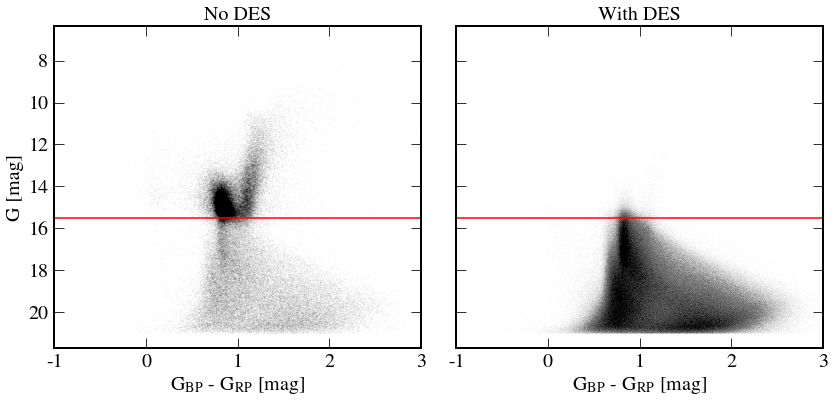

In [74]:
non_g = t['g']>50
non_i = t['i']>50

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
plt.sca(ax[0])
plt.plot(g.bp_rp[non_g | non_i], g.phot_g_mean_mag[non_g | non_i], 'k.', ms=0.5, alpha=0.05)
plt.axhline(15.5, color='r')

plt.gca().invert_yaxis()
plt.xlim(-1,3)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel('G [mag]')
plt.title('No DES', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.bp_rp[~non_g & ~non_i], g.phot_g_mean_mag[~non_g & ~non_i], 'k.', ms=0.5, alpha=0.01)
plt.axhline(15.5, color='r')

# plt.gca().invert_yaxis()
plt.xlim(-1,3)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
# plt.ylabel('G [mag]')
plt.title('With DES', fontsize='medium')

plt.tight_layout()

## Number of components

In [42]:
ncomp_array = np.arange(1,31,1, dtype='int')
bic_array = np.zeros_like(ncomp_array)

phi2_narrow_mask = np.abs(cj.phi2)<5*u.deg
for e, ncomp in enumerate(ncomp_array):
    data = np.array([cj.phi2[pm_mask & cmd_mask & phi1_mask & phi2_narrow_mask].to(u.deg).value]).T

    clf = sm.GaussianMixture(n_components=ncomp, covariance_type='full')
    clf.fit(data)
    labels = clf.predict(data)
    weight = clf.predict_proba(data)
    mean = clf.means_
    cov = clf.covariances_
    bic_array[e] = clf.bic(data)

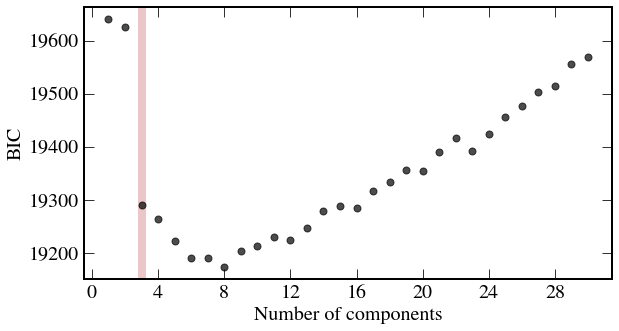

In [47]:
plt.figure(figsize=(9,5))
plt.plot(ncomp_array, bic_array, 'ko', ms=7, alpha=0.7)

plt.axvline(3, ls='-', color='firebrick', lw=8, alpha=0.25, zorder=0)

plt.xlabel('Number of components')
plt.ylabel('BIC')

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.tight_layout()

In [44]:
noptimal = 4

clf = sm.GaussianMixture(n_components=noptimal, covariance_type='full')
clf.fit(data)
labels = clf.predict(data)
weight = clf.weights_
mean = clf.means_
cov = clf.covariances_

In [45]:
rv_list = [None] * noptimal
x = np.linspace(-5,5,100)
y = np.zeros_like(x)
for e in range(noptimal):
    rv_list[e] = scipy.stats.norm(loc=mean[e][0], scale=cov[e][0][0])
    y = y + weight[e] * rv_list[e].pdf(x)

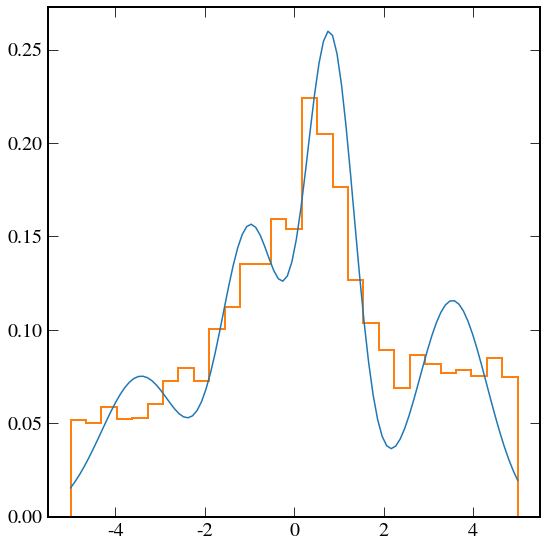

In [46]:
plt.plot(x, y, '-')
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask & phi2_narrow_mask].to(u.deg).value, 
                                  bins=bins, histtype='step', lw=2, normed=True)

plt.tight_layout()

## Contrast narrow and wide

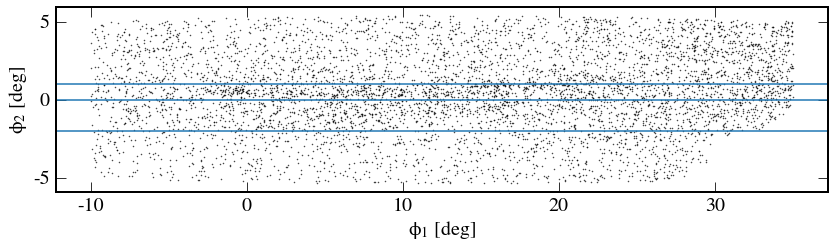

In [49]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.8)
plt.gca().set_aspect('equal')

plt.axhline(1)
plt.axhline(0)
plt.axhline(-2)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [134]:
phi1_parallel_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_parallel_mask & (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg)
wide_mask = phi1_parallel_mask & (cj.phi2<0*u.deg) & (cj.phi2>-2*u.deg)

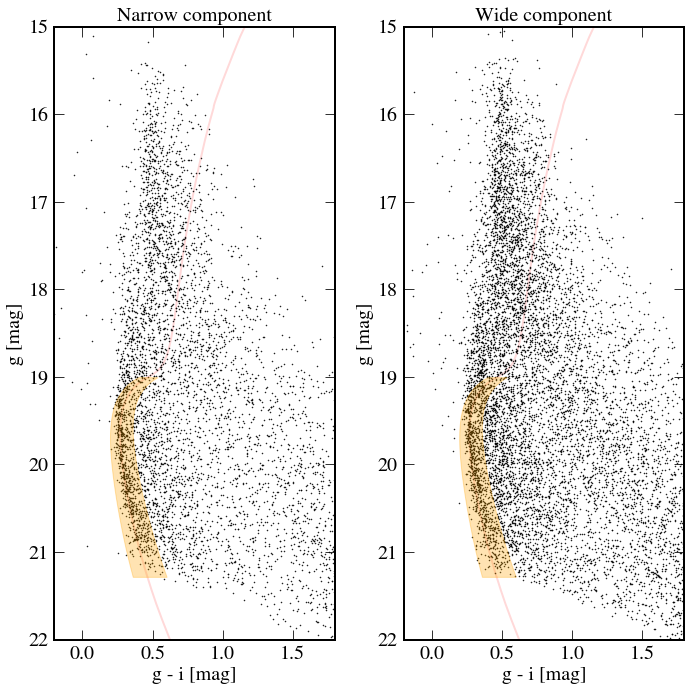

In [135]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
plt.sca(ax[0])
plt.plot(g.g0[narrow_mask & pm_mask] - g.i0[narrow_mask & pm_mask], g.g0[narrow_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlim(-0.2,1.8)
plt.ylim(22, 15)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Narrow component', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.g0[wide_mask & pm_mask] - g.i0[wide_mask & pm_mask], g.g0[wide_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlim(-0.2,1.8)
plt.ylim(22, 15)
plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')
plt.title('Wide component', fontsize='medium')

plt.tight_layout()

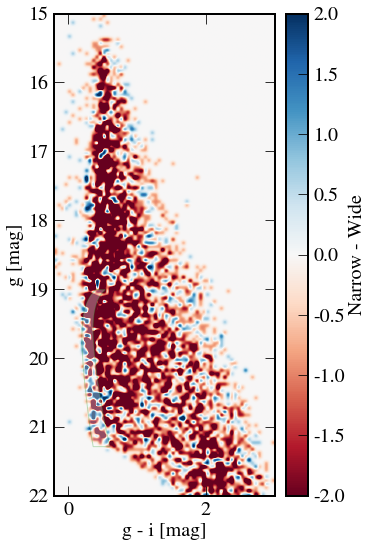

In [145]:
dmag = 0.05
bx = np.arange(-0.2,3+dmag,dmag)
by = np.arange(15,22+dmag,dmag)

Hon, bex, bey = np.histogram2d(g.g0[narrow_mask & pm_mask] - g.i0[narrow_mask & pm_mask], 
                               g.g0[narrow_mask & pm_mask], bins=(bx,by))

Hoff, bex, bey = np.histogram2d(g.g0[wide_mask & pm_mask] - g.i0[wide_mask & pm_mask], 
                               g.g0[wide_mask & pm_mask], bins=(bx,by))

Hdiff = Hon - Hoff

im = plt.imshow(Hdiff.T, origin='lower', extent=[-0.2,3,15,22], cmap='RdBu', vmin=-2, vmax=2,
          interpolation='gaussian')

pm = mpl.patches.Polygon(poly_main, color='w', alpha=0.3, zorder=2, label='', ec='tab:green')
plt.gca().add_artist(pm)

plt.xlim(-0.2,3)
plt.ylim(22,15)

plt.xlabel('g - i [mag]')
plt.ylabel('g [mag]')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="10%", pad=0.15)
plt.colorbar(im, cax=cax) #, ticks=np.arange(0,0.21,0.05))
plt.ylabel('Narrow - Wide')

plt.tight_layout()
plt.savefig('../plots/jhelum_cmd_diff.pdf')

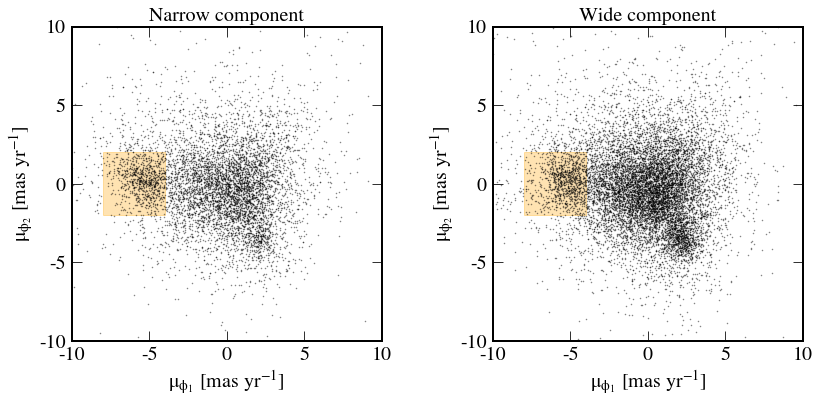

In [137]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Narrow component', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Wide component', fontsize='medium')

plt.tight_layout()

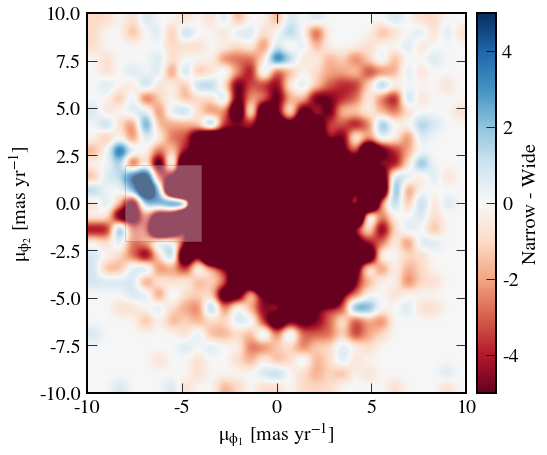

In [140]:
bx = np.linspace(-10,10,30)
Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[narrow_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[wide_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

# Hratio = np.zeros_like(Hon)
# Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
Hdiff = Hon - Hoff

im = plt.imshow(Hdiff.T, origin='lower', extent=[-10,10,-10,10], cmap='RdBu', vmin=-5, vmax=5,
          interpolation='gaussian')

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='white', alpha=0.3, ec='tab:green')
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
# plt.title('Narrow component - Wide component', fontsize='medium')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax) #, ticks=np.arange(0,0.21,0.05))
plt.ylabel('Narrow - Wide')

plt.tight_layout()
plt.savefig('../plots/jhelum_pm_diff.pdf')